# Cryptocurrency Trading Strategy

#### We will backtest , evaluate, and optimize a trading strategy that will be implemented in an algorthimic trading bot

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [13]:
def CryptoData(symbol, frequency):
    #Parameters: String symbol, int frequency = 300,900,1800,7200,14400,86400
    #Returns: df from first available date
    url ='https://poloniex.com/public?command=returnChartData&currencyPair='+symbol+'&end=9999999999&period='+str(frequency)+'&start=0'
    df = pd.read_json(url)
    df.set_index('date',inplace=True)
    return df

In [14]:
df = CryptoData(symbol = 'BTC_XRP', frequency = 300)
#When frequency = 300, data is refreshed every 5 minutes

We are interested developing a simple moving average (SMA) crossover strategy for trading Bitcoin and Ripple. A crossover is a relatively basic trading strategy that identifies shifts in price momentum that can be used as buy or sell signals. Our crossover strategy will consisit of a leading SMA and a lagging SMA. Leading SMA or the "short-term average" has less periods when calculating the average, so it is more sensitive to recent price changes. Lagging SMA or the "long-term average" has more periods, so it is less sensitive to recent price changes.

Text(0,0.5,'Price')

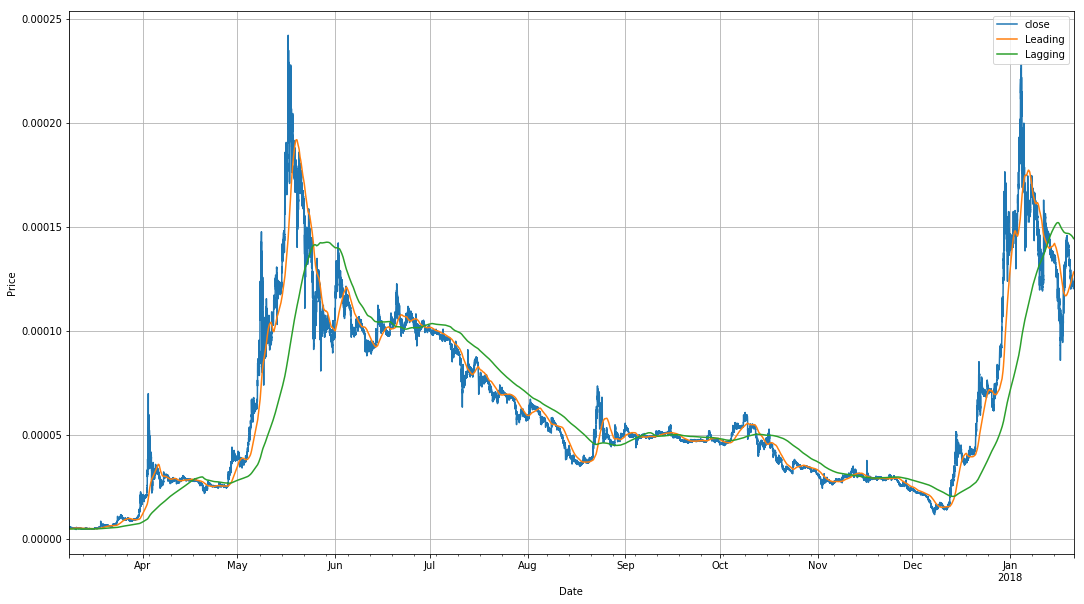

In [15]:
df['Leading'] = df['close'].rolling(1000).mean()
df['Lagging'] = df['close'].rolling(5000).mean()
df[['close','Leading','Lagging']][270000:].plot(figsize = (18,10), grid = True)
plt.xlabel('Date')
plt.ylabel('Price')

Trading Strategy: 
1. BUY if Leading SMA is ABOVE Lagging SMA by a certain threshold
2. SELL if Leading SMA is BELOW Lagging Simple Moving Avg. by a certain threshold

In [16]:
def test_ma(df, lead, lag, pc_thresh = 0.025):
    ma_df = df.copy()
    ma_df['lead'] = ma_df['close'].rolling(lead).mean()
    ma_df['lag'] = ma_df['close'].rolling(lag).mean()
    ma_df.dropna(inplace = True)
    ma_df['lead-lag'] = ma_df['lead'] - ma_df['lag']
    ma_df['pc_diff'] = ma_df['lead-lag'] / ma_df['close']
    ma_df['regime'] = np.where(ma_df['pc_diff'] > pc_thresh, 1, 0)
    ma_df['regime'] = np.where(ma_df['pc_diff'] < -pc_thresh, -1, ma_df['regime'])
    ma_df['Market'] = np.log(ma_df['close'] / ma_df['close'].shift(1))
    ma_df['Strategy'] = ma_df['regime'].shift(1) * ma_df['Market']
    ma_df[['Market','Strategy']] = ma_df[['Market','Strategy']].cumsum().apply(np.exp)
    return ma_df

The 'regime' column dictates the buying and selling logic. When the value changes to 1, we buy, and then we don't sell until it changes to -1. A 0 would mean we have no position and wait until the next buy or sell signal. The 'Market' column is the log returns of the change in price between BTC and XRP. The 'Strategy' column is our returns when using the SMA crossover strategy. It is computed by multipling 'regime' (shifted forward to match the 'Market' column) by 'Market'

In [17]:
ma_df = test_ma(df, 1000, 5000).dropna()
ma_df.tail()

,close,high,low,open,quoteVolume,volume,weightedAverage,Leading,Lagging,lead,lag,lead-lag,pc_diff,regime,Market,Strategy
date,,,,,,,,,,,,,,,,
2018-01-21 02:30:00,0.000121,0.000121,0.000121,0.000121,70085.247176,8.488753,0.000121,0.000128,0.000145,0.000128,0.000145,-0.000016,-0.133793,-1,14.267059,888.378311
2018-01-21 02:35:00,0.000121,0.000121,0.000121,0.000121,47595.163767,5.773322,0.000121,0.000128,0.000145,0.000128,0.000145,-0.000016,-0.133559,-1,14.258824,888.891401
2018-01-21 02:40:00,0.000120,0.000121,0.000120,0.000121,104566.198355,12.629430,0.000121,0.000128,0.000145,0.000128,0.000145,-0.000016,-0.134120,-1,14.165882,894.723344
2018-01-21 02:45:00,0.000121,0.000121,0.000120,0.000120,78604.828726,9.475065,0.000121,0.000128,0.000145,0.000128,0.000145,-0.000016,-0.133306,-1,14.218824,891.392006
2018-01-21 02:50:00,0.000121,0.000121,0.000120,0.000121,215505.940739,26.023375,0.000121,0.000128,0.000145,0.000128,0.000145,-0.000016,-0.132907,-1,14.227059,890.876026


In [7]:
ma_df[['Market','Strategy']].iloc[-1]

#Would have outperformed the market by a factor of about 46

Market       14.256471
Strategy    889.038107
Name: 2018-01-21 02:30:00, dtype: float64

Text(0,0.5,'BTC_XRP Return')

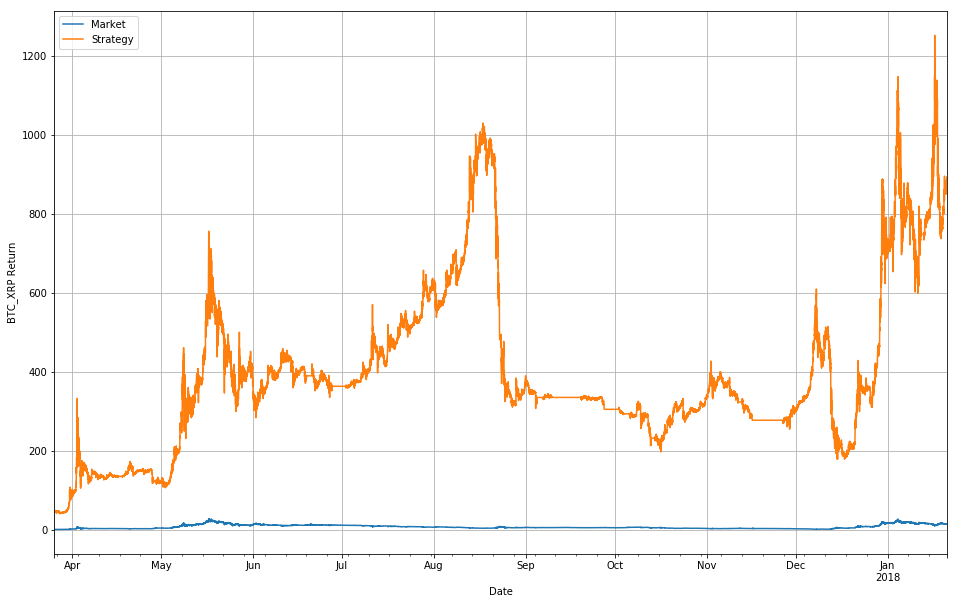

In [18]:
ma_df[['Market','Strategy']][270000:].plot(figsize = (16,10), grid = True)
plt.xlabel('Date')
plt.ylabel('BTC_XRP Return')

We can improve on the lead and lag moving average strategy by finding the combination of values that yields the highest return or profit and loss (PnL). We can create an array of lead and lag pairs, loop over the array with the returns using our strategy create a heatmap to indentify the best pairs.

In [19]:
leads = np.arange(100, 4100, 100)
lags = np.arange(4100, 8100, 100)
lead_lags = [[lead,lag] for lead in leads for lag in lags]
pnls = pd.DataFrame(index=lags,columns = leads)

In [20]:
for lead, lag in lead_lags:
    pnls[lead][lag] = test_ma(df, lead, lag)['Strategy'][-1]
    print(lead,lag,pnls[lead][lag])

100 4100 1.87292291614
100 4200 2.52130759459
100 4300 1.93767886164
100 4400 3.773596286
100 4500 4.59897326495
100 4600 6.70258923172
100 4700 4.45884690021
100 4800 5.21013353352
100 4900 5.34786891677
100 5000 3.4942410333
100 5100 5.23440975731
100 5200 6.1643584791
100 5300 4.48080381609
100 5400 4.02985992505
100 5500 3.35413905213
100 5600 3.00246597872
100 5700 2.21719805495
100 5800 2.84313363839
100 5900 2.61150582288
100 6000 3.31717540444
100 6100 3.20332430438
100 6200 3.44221223123
100 6300 2.44314125132
100 6400 1.64453950037
100 6500 2.2275866193
100 6600 2.66891890981
100 6700 1.39126584935
100 6800 0.95389731266
100 6900 0.808134494842
100 7000 1.05128553665
100 7100 0.679689099449
100 7200 1.08120828902
100 7300 1.29978953137
100 7400 1.35853080389
100 7500 0.956946712149
100 7600 1.04235350963
100 7700 1.25547543013
100 7800 1.27928141969
100 7900 0.789390258011
100 8000 0.953912759071
200 4100 15.7641701511
200 4200 18.732383516
200 4300 16.2223848079
200 4400 13.

900 7900 37.097891512
900 8000 45.5203035586
1000 4100 1655.7659027
1000 4200 1410.00282403
1000 4300 1107.83321183
1000 4400 1466.28545369
1000 4500 1247.01780218
1000 4600 1171.93222632
1000 4700 989.27285958
1000 4800 755.753983047
1000 4900 647.534457831
1000 5000 890.876025984
1000 5100 736.528447875
1000 5200 905.777452387
1000 5300 967.082059406
1000 5400 851.83445375
1000 5500 749.419287699
1000 5600 584.841840101
1000 5700 384.443924154
1000 5800 590.145298273
1000 5900 435.323615994
1000 6000 345.297401379
1000 6100 326.022252366
1000 6200 254.928165161
1000 6300 261.726335938
1000 6400 211.936433567
1000 6500 253.757780961
1000 6600 121.803523521
1000 6700 71.167052899
1000 6800 86.8926618892
1000 6900 113.44484314
1000 7000 103.303047678
1000 7100 104.162612796
1000 7200 147.073376241
1000 7300 84.8154052767
1000 7400 66.6912040937
1000 7500 40.9654456993
1000 7600 36.6608502442
1000 7700 32.0663621566
1000 7800 44.1302812277
1000 7900 47.0737884259
1000 8000 44.8578590791


1800 6300 45.1203979222
1800 6400 48.3219508926
1800 6500 67.333560554
1800 6600 45.8266784561
1800 6700 58.0256454141
1800 6800 34.1773282103
1800 6900 49.8382057486
1800 7000 37.6644134213
1800 7100 41.9411433834
1800 7200 42.8937462778
1800 7300 67.0954408391
1800 7400 38.8871683169
1800 7500 51.9297197499
1800 7600 42.6616323014
1800 7700 49.8348058986
1800 7800 76.4047789022
1800 7900 73.8495349773
1800 8000 72.3344807633
1900 4100 47.6141883303
1900 4200 44.5770565824
1900 4300 64.2244677947
1900 4400 92.2378772179
1900 4500 287.490976239
1900 4600 123.510174004
1900 4700 169.944293497
1900 4800 186.46914253
1900 4900 282.334758375
1900 5000 255.544146465
1900 5100 237.115977998
1900 5200 173.200811678
1900 5300 161.749037522
1900 5400 124.394608961
1900 5500 108.697275237
1900 5600 64.9310626315
1900 5700 59.7667053439
1900 5800 106.383174889
1900 5900 58.238470936
1900 6000 67.042503955
1900 6100 36.8693253838
1900 6200 70.7782580998
1900 6300 83.114675145
1900 6400 62.98009843

2700 4700 148.677974415
2700 4800 230.287254053
2700 4900 220.066844197
2700 5000 167.36482777
2700 5100 102.416260367
2700 5200 109.012047062
2700 5300 97.2673091441
2700 5400 68.1061886331
2700 5500 110.441469986
2700 5600 69.0193835553
2700 5700 59.4085206364
2700 5800 63.268665035
2700 5900 61.7463192016
2700 6000 50.3170412804
2700 6100 57.8289413879
2700 6200 38.9901871512
2700 6300 56.6745393441
2700 6400 55.808054843
2700 6500 40.0277553617
2700 6600 72.3631414637
2700 6700 104.672516353
2700 6800 73.184821501
2700 6900 43.7588067905
2700 7000 41.1395610898
2700 7100 57.9388764207
2700 7200 44.5106654069
2700 7300 47.4815472857
2700 7400 61.84727723
2700 7500 43.5299115719
2700 7600 78.6721562277
2700 7700 97.8883628364
2700 7800 96.2448316221
2700 7900 76.9237357775
2700 8000 78.7554148881
2800 4100 313.908856504
2800 4200 49.5307932452
2800 4300 81.1834661102
2800 4400 56.8008851367
2800 4500 128.85684453
2800 4600 108.298349794
2800 4700 83.6555922591
2800 4800 136.090439863

3500 7100 103.074853244
3500 7200 64.1324599649
3500 7300 66.5570700091
3500 7400 102.949460057
3500 7500 52.3837983653
3500 7600 50.3870036271
3500 7700 65.4884894977
3500 7800 63.8243820729
3500 7900 84.8355588858
3500 8000 76.4537763568
3600 4100 14.2993769099
3600 4200 97.34835915
3600 4300 127.527447231
3600 4400 1398.79218638
3600 4500 599.44629668
3600 4600 833.483775195
3600 4700 591.897582623
3600 4800 449.058294372
3600 4900 924.607539484
3600 5000 1655.96444132
3600 5100 707.792178585
3600 5200 1134.82494164
3600 5300 262.012715926
3600 5400 480.908295516
3600 5500 346.445815325
3600 5600 175.003602609
3600 5700 424.547763188
3600 5800 711.089105865
3600 5900 173.168096504
3600 6000 184.013167673
3600 6100 171.549327072
3600 6200 188.683225257
3600 6300 226.162306725
3600 6400 174.85613994
3600 6500 150.853896069
3600 6600 107.056341248
3600 6700 64.6198573037
3600 6800 80.9158339215
3600 6900 132.882028563
3600 7000 116.506226717
3600 7100 136.236444758
3600 7200 114.050592

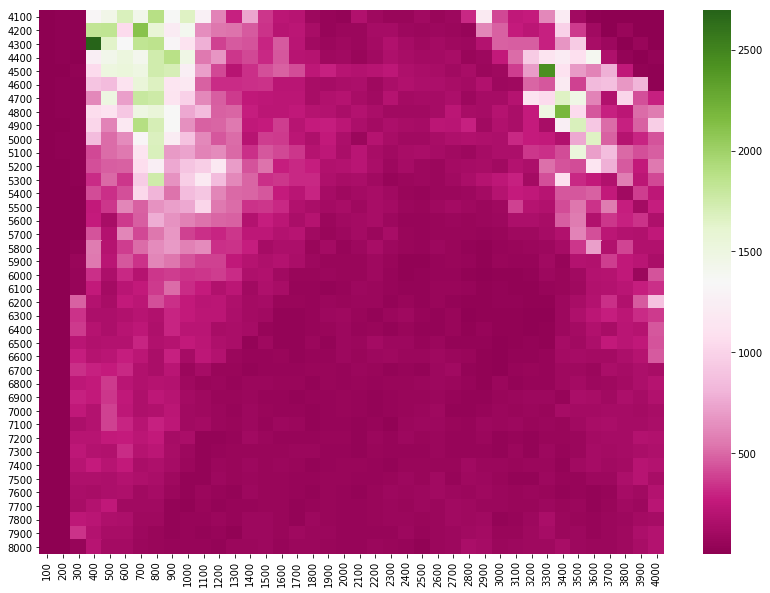

In [21]:
PNLs = pnls[pnls.columns].astype(float)
plt.subplots(figsize = (14,10))
sns.heatmap(PNLs,cmap= 'PiYG')

In [20]:
PNLs.max()

100        7.373847
200       22.874261
300      469.083245
400     3275.100281
500     2242.432250
600     2062.100524
700     2576.226911
800     2306.636633
900     2279.989386
1000    2021.868796
1100    1555.571151
1200    1153.046843
1300     686.861522
1400     911.021181
1500     517.937410
1600     582.589843
1700     502.390579
1800     307.699530
1900     346.089703
2000     243.485201
2100     220.630666
2200     237.727208
2300     266.616924
2400     199.981377
2500     153.911417
2600     225.759400
2700     243.647137
2800     341.563448
2900    1302.084636
3000     471.558468
3100     591.146561
3200    1086.801818
3300    2938.564586
3400    2396.907988
3500    1720.364427
3600    1621.504291
3700    1066.570687
3800    1001.334034
3900     789.800533
4000     948.796314
dtype: float64

A lead of 400 periods and lag of 4300 periods produces the max PnL.

Text(0,0.5,'Price')

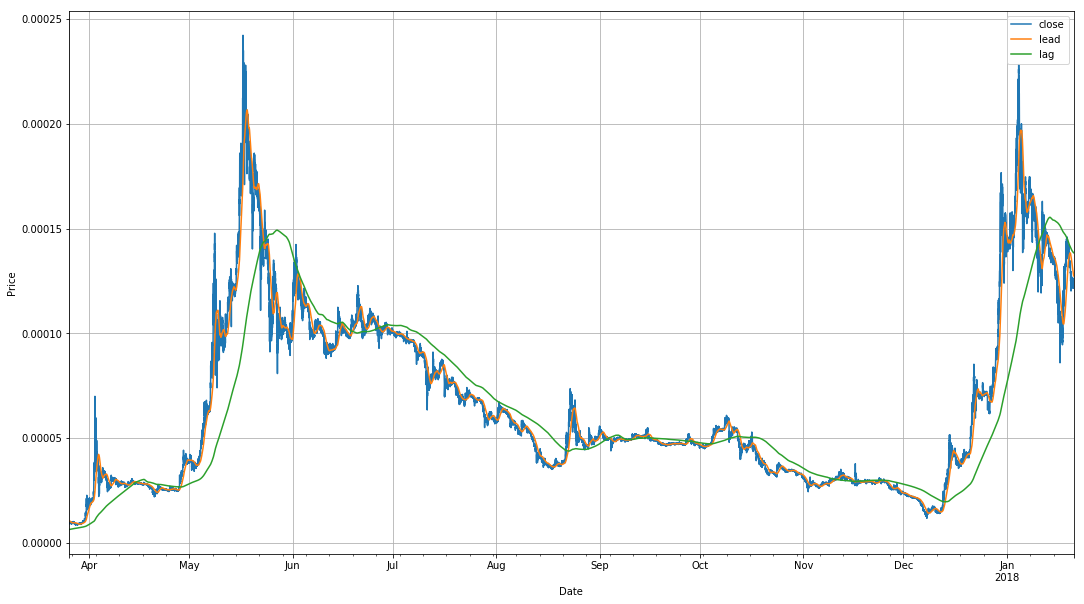

In [47]:
optimal_ma_df = test_ma(df, 400, 4300).dropna()
optimal_ma_df[['close','lead','lag']][270000:].plot(figsize = (18,10), grid = True)
plt.xlabel('Date')
plt.ylabel('Price')

Text(0,0.5,'BTC_XRP Return')

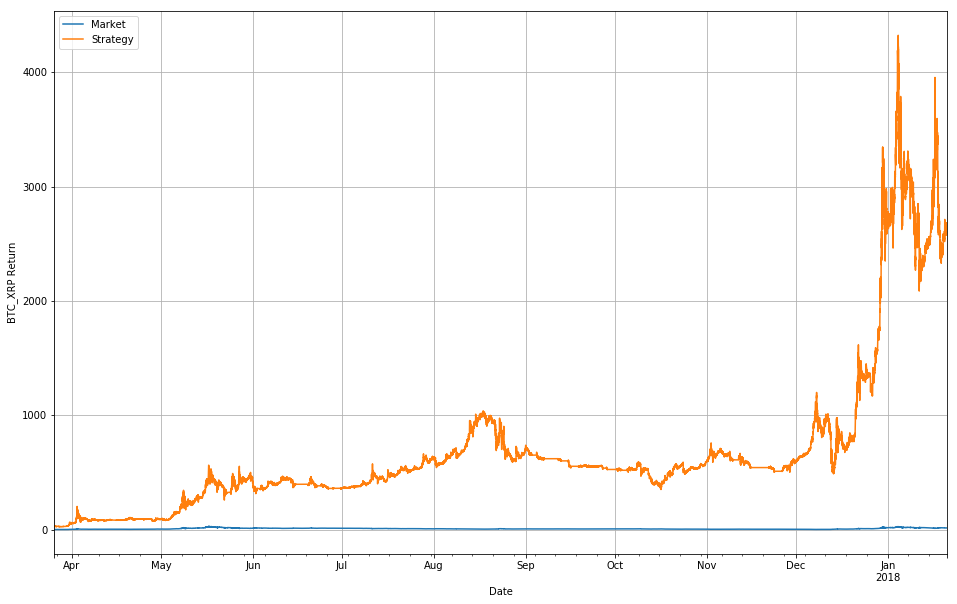

In [50]:
optimal_ma_df[['Market','Strategy']][270000:].plot(figsize = (16,10), grid = True)
plt.xlabel('Date')
plt.ylabel('BTC_XRP Return')

The next step would be to code an algorithmic trading bot that implements this strategy and interacts with an exchange's API.